# movie_mixer

Recomendation system to Recomend movies based on combined attributes of two or more movies.

[movielense-small dataset](https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset) is used for this project.

In [3]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns


movies = pd.read_csv("./dataset/movies.csv")
ratings = pd.read_csv("./dataset/ratings.csv")

Printing the five data in the movies dataframe.

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Similarly for ratings dataframe.

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Make new dataframe where each column would represent each unique userId and each row represents each unique movieId. This will create a rating matrix representing the ratings given by each user to each movies.

In [8]:
final_dataset = ratings.pivot(index="movieId", columns="userId", values="rating")
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


Replacing NaN with zero.

In [15]:
final_dataset.fillna(0, inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


Adding filters to make the rating reliable:

- A minimum of 10 votes is needed for a movie to qualify
- A user should atleast vote 50 movies to qualify 

Find the total number of user votes on each movies and total number of voting done by a user.

In [21]:
no_user_voted = ratings.groupby("movieId")["rating"].agg("count")
no_movies_voted = ratings.groupby("userId")["rating"].agg("count")

Visualizing the data.

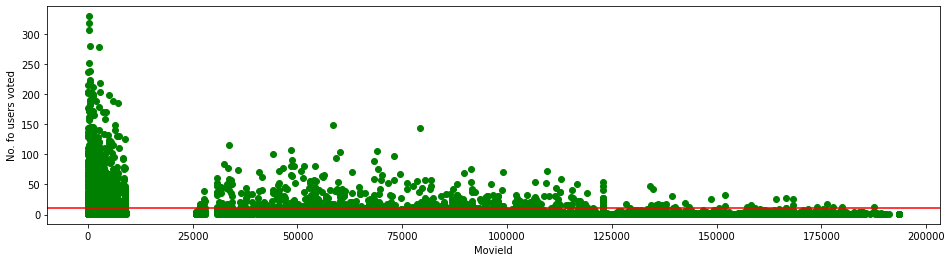

In [24]:
f, ax = plt.subplots(1, 1, figsize=(16, 4))

plt.scatter(no_user_voted.index, no_user_voted, color="g")
plt.axhline(y=10, color="r")
plt.xlabel("MovieId")
plt.ylabel("No. fo users voted")
plt.show()

Modifying data as per threshold.

In [25]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index, :]

Visualizing the data.

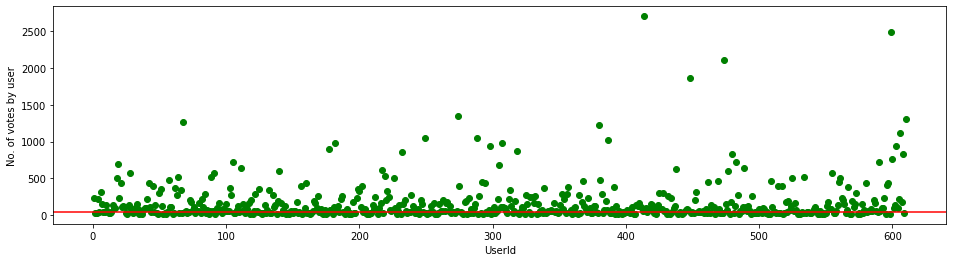

In [27]:
f, ax = plt.subplots(1, 1, figsize=(16, 4))

plt.scatter(no_movies_voted.index, no_movies_voted, color="g")
plt.axhline(y=50, color="r")
plt.xlabel("UserId")
plt.ylabel("No. of votes by user")
plt.show()

Modifying data as per threshold.

In [29]:
final_dataset = final_dataset.loc[:, no_movies_voted[no_movies_voted > 50].index]

final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To remove the sparsity of data, csr_matrix function from the scipy library is used.

In [30]:
csr_data = csr_matrix(final_dataset)
final_dataset.reset_index(inplace=True)

KNN with cosine distance is used for clustering.

In [46]:
knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

Search the given movie in our dataset if available output top 10 movies with shortest distance from the input movie.

In [47]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies["title"].str.contains(movie_name)]
    
    if len(movie_list):
        movie_idx = movie_list.iloc[0]["movieId"]
        movie_idx = final_dataset[final_dataset["movieId"]==movie_idx].index[0]
        distance, indices = knn.kneighbors(csr_data[movie_idx], n_neighbors=n_movies_to_reccomend+1)
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distance.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]["movieId"]
            idx = movies[movies["movieId"]==movie_idx].index
            recommend_frame.append({"Title":movies.iloc[idx]["title"].values[0],"distance":val[1]})
        df = pd.DataFrame(recommend_frame, index=range(1, n_movies_to_reccomend+1))
        return df
    else:
        return "NO movies found in our server!!!"
            

In [58]:
get_movie_recommendation("The Revenant")

,Title,distance
1,John Wick (2014),0.450602
2,"Wolf of Wall Street, The (2013)",0.447583
3,Interstellar (2014),0.447008
4,Arrival (2016),0.442166
5,The Hateful Eight (2015),0.429966
6,Ex Machina (2015),0.423520
7,Django Unchained (2012),0.421573
8,Mad Max: Fury Road (2015),0.368251
9,The Martian (2015),0.368165
10,Snowpiercer (2013),0.329100


Dumping movies and final_dataset.

In [62]:
import pickle

pickle.dump(movies, open("./pickles/movies.p", "wb"))
pickle.dump(final_dataset, open("./pickles/final_dataset.p", "wb"))